# Tutorial: How to run erro mitigated state reconstruction.

## Import files and libraries

In [3]:
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from functools import reduce

## Example of how to run REM overlapping tomography
For this we require a perfect family of hashing functions, denoted by $(N,k,m,m)$, where $N$ is the totoal number of hashing fuctions, $k$ is the size of the total system and m is teh size of the subsystem you want to reconstruct arbitrary correlators. The number of hashing functions scales exponentially in $k$, but logarithmically in $m$.

Overlapping tomography can be done in 3 steps:
1. Overlapping QDT (calibtrate such that that arbitrary POVMs can be reconstructed)
    1. Create a set of calibration states according to hashing function. This is effectivly to split total system up into $m$ subgroups that are effectivly treated as a single qubit. This means the set of calibration states scales as $4^m$.
    2. For each hashing function, measure the complete set of calibration states in the computational basis. 
    3. Select subsystem(s) of qubit(s) of at most $m$ indices and trace down the total set of measurements such that it only contains structure of the qubits of interest. 
    4. Perform standard QDT with the traced down set of calibration states and accompanying outcomes to create the learned noisy POVM of the subsystem. 

2. Perform overlapping tomography measurements. (See original paper [here](https://link.aps.org/doi/10.1103/PhysRevLett.124.100401))
    1. Use the same hashing functions from step 1. and create a set of Pauli-6 measurements from these hashing functions. (Similarly as before, it splits the whole system into $m$ subsystems that are effecitvly treated as a single qubit. One then perform an IC POVM on these effective single qubits.) Each hasing function is a different assignment over the whole qubit system.
    2. Measure the qubit system of interest with the hashed Pauli-6 POVMs.
    
3. Perform REM overlapping tomography with overlapping POVM reconstructions. 
    1. Select the same subsystem qubit indices as in 1.3 and create a $m$ qubit Pauli-6 POVM out of them by applying rotations to the reconstructed computational basis for the selected qubit indecies. In this case one can effectively ignore all other qubits and just create a $m$ qubit Pauli-6 POVM fromt he $m$ qubit computational basis POVM.  
    2. For the selected subsystem qubit indices trace down the measurements on the whole system such that it only constain the $m$ qubit Pauli-6 structure on the relevant subsystem. Here we also need to 
    3. Perform REMQST with the traced down data from 3.2 and the rotated traced down Pauli-6 from step 3.1.

With this you should be able to recreate arbitrary $m$ qubit density matrices that are readout error mitigated on that $m$ qubit domain, and effectivly ignored the effect of all other qubits in the total system. 

### 1. Overlapping QDT

In [23]:
# Define the additional overhead functions (will me moved to library later on)

def measure_hashed_calibration(n_shots,povm,hash_family,one_qubit_calibration_states,n_hash_symbols):
    """
    Function takes in a hash function and a creates set of calibration states,
    and returns the list of measurements.
    
    Outcomes has shape [n hash, n_calib, 2**n_qubts,2**n_qubts ]
    """
    calib = np.array([sf.generate_calibration_states_from_hash(function,one_qubit_calibration_states,n_hash_symbols) for function in hash_family])
    outcomes = np.array([[mf.measurement(n_shots,povm,rho) for rho in hash_rho] for hash_rho in calib])
    return outcomes
    
def downconvert_index_counts_and_calibration_states(traced_down_index,outcomes,one_qubit_calibration_states,n_hash_symbols ):
    """
    Takes in index of the qubits of intrest and the full set of measurements on the whole system and
    traces it down to the outcomes on the system of interest, and provies the set of calibraton states on the relevant system. 
    """
    downconverted_outcomes = sf.downconvert_outcomes(traced_down_index,outcomes)
    # 1) Make sure index list inversly sorted, to make sure low index is to the right
    qubit_index = np.sort(traced_down_index)[::-1]
    #print(qubit_index)
    # subtract the lenght of the qubit chain to make the qubit index match the storage index. 
    calib_qubit_index = 3 - qubit_index

    # NOTE Qubit index counts from the wrong side, qubit 0 is index -1


    calib_state = np.array([sf.generate_calibration_states_from_hash(function,one_qubit_calibration_states, n_hash_symbols) for function in hash_family[:,calib_qubit_index]])
    shape_calib = calib_state.shape
    index_counts =  np.array([[np.bincount(outcomes,minlength=2**len(traced_down_index)) for outcomes in calib_state] for calib_state in downconverted_outcomes])
    shape_index = index_counts.shape
    return index_counts.reshape((shape_index[0] * shape_index[1], shape_index[2])), calib_state.reshape((shape_calib[0] * shape_calib[1], shape_calib[2], shape_calib[3]))


# Either load in the hashing function from file or simply use easy test:
hash_family = np.array([[1,0,1,0,1,0],[0,1,0,1,0,1]])
# Define parameters
n_qubits = 6
n_shots = 10**5
subsystem_index = np.array([4,1])
n_hash_symbols = len(subsystem_index)
n_hash = len(hash_family)
comp_POVM = POVM.computational_basis_POVM(n_qubits)[0]
noisy_POVM = POVM.depolarized_POVM(comp_POVM)

# Define an IC calibration basis, here we use the SIC states (by defining the angles (as will be used for state preparation))
one_qubit_calibration_angles = np.array([[[0,0]],[[2*np.arccos(1/np.sqrt(3)),0]],
                                                 [[2*np.arccos(1/np.sqrt(3)),2*np.pi/3]],
                                                 [[2*np.arccos(1/np.sqrt(3)),4*np.pi/3]]])
#one_qubit_calibration_angles = np.array([[[0,0]],[[np.pi,0]]])

one_qubit_calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in one_qubit_calibration_angles])

# Measure in the hashed bases (step 1.1 and 1.2): 
outcomes = measure_hashed_calibration(n_shots,comp_POVM,hash_family,one_qubit_calibration_states, n_hash_symbols)
# Outcomes has shape [n hash, n_calib, 2**n_qubts,2**n_qubits ]

# Create traced down subsystem outcomes and calibration stataes (step 1.3): 
index_counts ,calib_state = downconvert_index_counts_and_calibration_states(subsystem_index,outcomes,one_qubit_calibration_states,n_hash_symbols)

# Step 1.4 Reconstruct the subsystem POVM
guess_POVM = POVM.computational_basis_POVM(len(subsystem_index))[0]
reconstructed_comp_POVM = dt.POVM_MLE(2,index_counts,calib_state,guess_POVM)
noisy_guess_POVM = POVM.depolarized_POVM(guess_POVM) # For comparison
# 
conv = dt.POVM_convergence(reconstructed_comp_POVM.get_POVM(),guess_POVM.get_POVM())
noisy_conv = dt.POVM_convergence(reconstructed_comp_POVM.get_POVM(),noisy_guess_POVM.get_POVM())
print(f'Noiseless convergence {conv}')
print(f'Noisy convergence {noisy_conv}')

(4, 4, 4)
(32, 4, 4)
	Number of MLE iterations: 2000, final distance 3.6227074427103156e-08
Noiseless convergence 0.0035045239141561005
Noisy convergence 0.17251070254723494


### 2. Overlapping tomograpahy measurements

In [24]:
def measure_hashed_POVM(n_shots, hashed_POVM, rho, return_frequencies = False):
    outcomes = np.array([[mf.measurement(n_shots, povm, rho, return_frequencies = return_frequencies) for povm in povm_list] for povm_list in hashed_POVM ])
    return outcomes


# Step 2.1 Create the set of POVMs to perform overlapping tomography with
hashed_POVM =np.array([ POVM.generate_Pauli_from_hash(function, n_hash_symbols) for function in hash_family ])
print(f'Hash family \n {hash_family}') 
#print(hashed_POVM.shape)


# Step 2.2 Measure the total system in the hashed basis.

# Generate true state to samples
rho_true_list = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
rho = reduce(np.kron, rho_true_list) 


# The state ordering is as follows rho_0 cross rho_1 ...., meaning the rho_0 is the last qubit form qubit index. 
return_frequencies = True
#print(hashed_POVM.shape)
QST_outcomes = measure_hashed_POVM(n_shots, hashed_POVM, rho, return_frequencies = return_frequencies)

Hash family 
 [[1 0 1 0 1 0]
 [0 1 0 1 0 1]]


## 3. Overlapping REMQST

In [25]:
# Step 3.1 Create Pauli-6 POVM out of the reconstructed computational basis measurements

reconstructed_Pauli_POVM = POVM.generate_Pauli_from_comp(reconstructed_comp_POVM)

# print(reconstructed_Pauli_POVM.shape)
# print(reconstructed_Pauli_POVM[0].get_POVM().shape)

# Step 3.2 downconvert the QST results to the corresponding subsystem


# i) downconvert the frequencies to be in the right shape
downconverted_frequenceis = sf.downconvert_frequencies(subsystem_index,QST_outcomes.reshape((n_hash * 3**n_hash_symbols, 2**n_qubits)))


# ii) Create the POVM list that assosicated to each row in the downconverted frequency list

def get_downconvted_Pauli_order_from_hash(function, subsystem_index, Pauli_POVM):
    """
    Function takes in hash_function and the full reconstructed Pauli POVM from the subsystem and returns
    a list of Pauli measurement that correspond to the order they appear in downconverted frequencies. 
    
    """
    print(function)
    n_qubit_subsystem = len(subsystem_index)
    n_total_qubits = len(function)
    # Assume subsystem index is sorted. 
    subsystem_index = np.sort(subsystem_index)
    options = np.array([0, 1, 2])
    #options_check = np.array(["X","Y", "Z"])
    comb_list = np.array(list(product(options, repeat=n_qubit_subsystem)))[:,::-1]
    #comb_list_check = np.array(list(product(options_check, repeat=n_qubit_subsystem)))[:,::-1]
    reduced_hash = function[np.sort(n_total_qubits-1 - subsystem_index)]
    print(reduced_hash)
    sample_list = comb_list[:,reduced_hash]
    #sample_list_check = comb_list_check[:,reduced_hash]
    #print(sample_list)
    #print(sample_list_check)
    base_3 = np.array([3**i for i in range(n_qubit_subsystem)])[::-1]
    #print(base_3[])
    povm_outcome_list = np.array([Pauli_POVM[np.dot(entry,base_3)] for entry in sample_list])
    #povm_outcome_list_check = np.array([Pauli_POVM[np.dot(entry,base_3)] for entry in sample_list])
    
    
    return povm_outcome_list

downconverted_POVM =np.array([get_downconvted_Pauli_order_from_hash(function,subsystem_index,reconstructed_Pauli_POVM) for function in hash_family])


# Step 3.3 Perform state reconstruction with both the POVM list and results

def changedMLE(OP_list: np.array, index_counts: np.array ):
    '''
    Estimates state according to iterative MLE.
    :param full_operator_list: full list of POVM elemnts
    :outcome_index: list of all outcome_indices such that
            full_operator_list[index] = POVM element
    :return: dxd array of iterative MLE estimator
    '''
    dim = OP_list.shape[-1]

    iter_max = 1000
    dist     = float(1)

    rho_1 = np.eye(dim)/dim
    rho_2 = np.eye(dim)/dim
    j = 0

    #unique_index, index_counts=np.unique(outcome_index,return_counts=True)
    #OP_list=full_operator_list[unique_index]
    #print(f" op list{np.sum(OP_list,axis = 0)}")
    #print(OP_list.shape)
    #print(rho_1.shape)
    while j<iter_max and dist>1e-14:
        p      = np.einsum('ik,nki->n', rho_1, OP_list)
        R      = np.einsum('n,n,nij->ij', index_counts, 1/p, OP_list)
        update = R@rho_1@R
        rho_1  = update/np.trace(update)

        if j>=40 and j%20==0:
            dist  = sf.one_qubit_infidelity(rho_1, rho_2)
        rho_2 = rho_1

        j += 1

    return rho_1
full_operator_list=np.array([a.get_POVM() for a in downconverted_POVM.reshape(n_hash * 3**n_hash_symbols)])
full_operator_list=np.reshape(full_operator_list,(-1,2**2,2**2))
rho_recon = changedMLE(full_operator_list,downconverted_frequenceis.reshape(n_hash * 3**n_hash_symbols * 2**n_hash_symbols))

# Check all possible infidelities
# for i in range(4):
#     for j in range(4):
#         inf = sf.one_qubit_infidelity(rho_recon,np.kron(rho_true_list[i],rho_true_list[j]))
#         print(f'Final infidelity {inf}, ({i}, {j})')

# Change order of subsystem_inex to make it correspond to qubit order
qubit_index = n_qubits - 1 - subsystem_index
#print(qubit_index)
qubit_sublist = rho_true_list[qubit_index]
inf = sf.one_qubit_infidelity(rho_recon,reduce(np.kron, qubit_sublist))
#inf_2 = sf.one_qubit_infidelity(rho_recon,np.kron(qubit_sublist[1],qubit_sublist[0]))

print(f'Final infidelity {inf}')
#print(f'Final infidelity {inf_2}')

[1 0 1 0 1 0]
[0 1]
[0 1 0 1 0 1]
[1 0]
Final infidelity 0.0004003592230785724


## Example of how to run Benchamking on REM. 
Define operational parameters for the simulation and error mitigation.

In [3]:
bool_exp_measurements = False # Whether to call experimental sampling function or not
n_qubits = 4
n_QST_shots = 10**4 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly)
n_calibration_shots = 10**4 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 8 # Available cores for parallell resampling of BME
n_averages = 1 # Only used if you generate true states generate_random_pure_state()
method="MLE" # Defines what type of state reconstruction can be done, either "MLE" or "BME" (BME supports only 2 qubits).
calibration_mode = "SIC"

noise_mode = 3 # Noise mode if using synthetic measurement
# For 1 qubit
# 0: No noise
# 1: Depolarizing noise
# 2: Stronger depolarized noise
# 3: Amplitude damping
# 4: Constant rotation around x-axis

# For 2 qubits:
# 0: No noise
# 1: CNOT noise
# 2: ISWAP noise
# 3: Constant random rotation
# 4: Constant factorized rotation
# 5: Small facotrized overrotation
# 6: Small x rotation only on first qubit
# 7: Strong depolarizing


synthetic_name_list = ["CNOT","ISWAP" ,"2_qubit_random_rotation", 
                       "facotrized_2_qubit_random_rotation", "small_factorized_overrotation",
                       "x-axis_first_qubit","2_qubit_depolarizing"]
# For more than 2 qubits: 
# Any non-zero is depolarizing noise


# Generating (Haar) random n-qubit pure states. (Contains entangled states)
list_of_true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])

# Generating factorizie n-qubit pure states (q_0 x q_1 x ... x q_n-1) where each single qubit is Haar random.
list_of_true_states, list_of_true_state_angles = sf.generate_random_factorized_states(n_qubits,n_averages)

#print(list_of_true_states)
#print(list_of_true_state_angles)
# If you want to connect your own experiment, you need to define a measurement function
# and supply it with the experimental dictionary. The experimetnal dictionary will be passed
# to the experimental measurement function, which should contain all parameters required to run
# the experiment.

# Example of the experimental measurement function.
 
def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(n_shots)
    #print(POVM_angles)
    #print(true_state_angles)
    return np.random.randint(low=0,high=2**n_qubits,size=(n_shots))

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }

Running the default simulation.

In [4]:
# Calling the error mitigated QST. The function returns the set of mitigated and unmitigated infidelities
# for comparison. It alo supplies the list of error mitigated state estimates.
# In addition all run parameters are saved to a files in result.
results = emqst.emqst(n_qubits,n_QST_shots,n_calibration_shots,
                       list_of_true_states,bool_exp_measurements = bool_exp_measurements,
                       exp_dictionary = exp_dictionary,
                       n_cores = n_cores, noise_mode = noise_mode,calibration_mode = calibration_mode, 
                       true_state_angles_list=list_of_true_state_angles, method=method)


POVM calibration states are SIC.
----------------------------
Error corrected MLE.
4 qubit(s).
2560000 POVM calibration shots.
810000 QST shots.
1 QST averages.
----------------------------
Synthetic noise mode 3.
Done collecting and sorting QDT data, total runtime 10.937994241714478.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 288.4858341217041
Runtime of DT reconstruction 299.4238283634186
Distance between reconstructed and noisy POVM: 0.005870061068803157
Distance between reconstructed and noisy POVM: 0.00559564135274199
Distance between reconstructed and noisy POVM: 0.005967809593613184
Distance between reconstructed and noisy POVM: 0.005613887354312376
Distance between reconstructed and noisy POVM: 0.005670377488768256
Distance between reconstructed and noisy POVM: 0.005925257683174125
Distance between reconstructed and noisy POVM: 0.0058726665543170735
Distance between reconstructed and noisy POVM: 0.0055087861680671035
Distance between reconstructed and

Work with the results

In [18]:

# Check what is stored in the results
key_list = list(results.keys())
print(f"List of keys {key_list}")
# Select the list of elements you want
index = 3 # Select the reconstructed POVM.

result_I_want = results[key_list[index]]
print(result_I_want.shape)
rho = results["corrected_rho_estm"]
#print(rho)
#print(np.trace(rho[0]@rho[0]))
# The reconstructed POVM has the following form. 
# The first index selects what spin-measurement was reconstructed, it follows the pattern 
# XX, XY, XZ, YX ... in total 9. 
# The second indes gives the outcome, and follows pattern (up up), (up down), (down up), (down down), 
# The last two dimension are the matrix dimensions. 

# Example, I want to look at the post-measurement state from outcome (up down) in XX direction. 
#M = result_I_want[8,0]
#print(M)
inf = results[key_list[0]]
uninf = results[key_list[1]]
print(inf[:,-1])
print(uninf[:,-1])


# sampled_POVM = results["reconstructed_POVM"]
# path = 'data/synthetic_sampled_povms/'
# name = synthetic_name_list[noise_mode-1]
# np.save(path+name+".npy",result_I_want)

# sythetic_POVM = results["synthetic_POVM"]
# path2 = 'data/synthetic_exact_povms/'
# np.save(path2+name+".npy",sythetic_POVM)

List of keys ['corrected_infidelity', 'uncorrected_infidelity', 'corrected_rho_estm', 'reconstructed_POVM', 'synthetic_POVM']
(27, 8, 8, 8)
[0.00597346 0.00745075 0.00552214 0.00627152 0.00796063 0.00736956
 0.00411507 0.00859269 0.00577862 0.00618379]
[0.08718379 0.08920608 0.08912059 0.08635695 0.09174171 0.08485345
 0.08868026 0.08998744 0.08850907 0.08821722]


Visualization

In [7]:

vis.plot_POVM_folder(path2)

Plotting POVM lists from data/synthetic_exact_povms/.
2_qubit_depolarizing
2_qubit_random_rotation
CNOT
facotrized_2_qubit_random_rotation
ISWAP
small_factorized_overrotation
x-axis_first_qubit


1

## Example how to run comparative REM with same data. 

Explcite walkthrough of how the data downconversion works. 

In [ ]:

n_qubits = 1
    
print("Downconversion happens in 3 steps;") 
print(" 1) Outcomes")
print(" 2) Calibration states")
print(" 3) POVMs")
# n_qubits is the target qubit size. 

print("Step by step explaination of what happenes. Initial list created simplified 2 qubit structure." )
arr=np.reshape(np.arange(9*12*4),(9,12,4))
print( "Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)" )

print(f'Select outcome of first POVM (XX) \n{arr[0]}')
print("Sum over calibration states (They go x+x+, x+x- ,...) so every 6.")
print(np.array([np.sum(arr[0,j::6**n_qubits],axis=0) for j in range(6**n_qubits) ]))
print("Perform for each of these rows sum over every second outcome")
print(np.array([np.sum(np.array([np.sum(arr[0,j::6**n_qubits],axis=0)[k::2**n_qubits] for k in range(2**n_qubits)]),axis=1) for j in range(6**n_qubits) ]))
    
print("Now do this for each of the POVMS separatly")    
arr_2 = np.array([np.array([np.sum(np.array([np.sum(arr[k,i::6**n_qubits],axis=0)[j::2**n_qubits] for j in range(2**n_qubits)]),axis=1) for i in range(6**n_qubits)]) for k in range(len(arr))])
print(arr_2)

# Downconvert POVM
print("In the final step we need to downconver the POVMs, XX, XY, XZ, YX, so every 3rd POVM should be summed")
arr_3 = np.array([np.sum(arr_2[i::3**n_qubits],axis=0) for i in range(3**n_qubits)])
print(arr_3)



def downconvert_QDT_counts(index_counts,to_qubits,):
    arr_1 = np.array([np.array([np.sum(np.array([np.sum(index_counts[k,i::6**to_qubits],axis=0)[j::2**to_qubits] for j in range(2**to_qubits)]),axis=1) for i in range(6**to_qubits)]) for k in range(len(index_counts))])
    arr_2 = np.array([np.sum(arr_1[i::3**to_qubits],axis=0) for i in range(3**to_qubits)])
    return arr_2




Downconversion happens in 3 steps;
 1) Outcomes
 2) Calibration states
 3) POVMs
Step by step explaination of what happenes. Initial list created simplified 2 qubit structure.
Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)
Select outcome of first POVM (XX) 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]]
Sum over calibration states (They go x+x+, x+x- ,...) so every 6.
[[24 26 28 30]
 [32 34 36 38]
 [40 42 44 46]
 [48 50 52 54]
 [56 58 60 62]
 [64 66 68 70]]
Perform for each of these rows sum over every second outcome
[[ 52  56]
 [ 68  72]
 [ 84  88]
 [100 104]
 [116 120]
 [132 136]]
Now do this for each of the POVMS separatly
[[[  52   56]
  [  68   72]
  [  84   88]
  [ 100  104]
  [ 116  120]
  [ 132  136]]

 [[ 244  248]
  [ 260  264]
  [ 276  280]
  [ 292  296]
  [ 308  312]
  [ 324  328]]

 [[ 436  4

In [ ]:
# Testing simultanious 2 and 1 qubit QDT
n_qubits=2
downconvert_to_qubits = 1
n_QDT_shots_each = 10**6 
n_QST_shots_each = 10**6
n_averages = 10
n_cores = 1
noise_mode = 2
exp_dictionary = {}
bool_exp_measurements = False

base_POVM_list = POVM.generate_Pauli_POVM(n_qubits)

noisy_POVM_list = np.array([POVM.depolarized_POVM(povm) for povm in base_POVM_list])

#noisy_POVM_list = np.array([POVM.generate_noisy_POVM(povm,noise_mode) for povm in base_POVM_list])
original_POVM, downconverted_POVM = dt.donwconverted_device_tomography(n_qubits, downconvert_to_qubits,n_QDT_shots_each,noisy_POVM_list,n_cores=n_cores)

print(original_POVM[0].get_POVM().shape)
print(downconverted_POVM[0].get_POVM().shape)



print("POVM calibration complete.\n----------------------------")

list_of_true_states_small = np.array([sf.generate_random_pure_state(downconvert_to_qubits) for _ in range(n_averages)])
list_of_true_states_large = np.array([np.kron(sf.generate_random_pure_state(n_qubits - downconvert_to_qubits),list_of_true_states_small[i]) for i in range(n_averages)])

#print(list_of_true_states_small.shape)
#print(list_of_true_states_large.shape)
qst_large = QST(POVM.generate_Pauli_POVM(n_qubits),list_of_true_states_large,n_QST_shots_each,n_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=original_POVM)
qst_small = QST(POVM.generate_Pauli_POVM(downconvert_to_qubits),list_of_true_states_small,n_QST_shots_each*3,downconvert_to_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=downconverted_POVM)
qst_large.generate_data(override_POVM_list=noisy_POVM_list)
outcomes = qst_large.get_outcomes()

qst_large.perform_MLE(override_POVM_list=original_POVM)
rho_large = qst_large.get_rho_estm()
infid_large = 1  - np.real(np.einsum('kij,kji->k',rho_large, list_of_true_states_large))

#print(infid_large)
# Downconvert the outcome indecies:
# We assume that we remove the first index, so we need to modulo the whole outcome set by 6. 
downconverted_outcomes = np.floor_divide(outcomes%12,2*2)*2  + (outcomes%12)%2
print(f'Large infidelity: {infid_large}\nAverage {np.average(infid_large)}')

qst_small.set_outcomes(downconverted_outcomes)

qst_small.perform_MLE(override_POVM_list=downconverted_POVM)

rho_small = qst_small.get_rho_estm()

rho_large_traced_down = np.einsum('nijil->njl', np.reshape(rho_large, (n_averages,2, 2, 2, 2)))

infid = 1 - np.real(np.einsum('kij,kji->k',rho_small,list_of_true_states_small))
print(f"Small infidelity: {infid}\nAverage {np.average(infid)}")

infid = 1 - np.real(np.einsum('kij,kji->k',rho_large_traced_down,list_of_true_states_small))
print(f"Traced down infidelity: {infid}\nAverage {np.average(infid)}")



Done collecting and sorting QDT data, total runtime 8.169024467468262.
Starting POVM reconstruction.
	Number of MLE iterations: 450, final distance 2.390697084742044e-10
	Number of MLE iterations: 450, final distance 2.6646712614208923e-10
	Number of MLE iterations: 450, final distance 9.45095945947827e-11
	Number of MLE iterations: 450, final distance 2.6197861935362e-10
	Number of MLE iterations: 500, final distance 8.789324823510469e-11
	Number of MLE iterations: 500, final distance 1.0007440709447479e-10
	Number of MLE iterations: 450, final distance 2.9443580212840104e-10
	Number of MLE iterations: 500, final distance 9.03015717756972e-11
	Number of MLE iterations: 450, final distance 1.3566179429824743e-10
Runtime of parallel POVM reconstruction 2.045966148376465
Starting downconverted POVM reconstruction.
	Number of MLE iterations: 50, final distance 1.478261957288396e-13
	Number of MLE iterations: 50, final distance 2.4659163599949352e-11
	Number of MLE iterations: 50, final di

In [ ]:
n_qubits=2
test = np.arange(6**n_qubits)
test=np.reshape(test,(9,4))
test2 = test%12
test3 = np.floor_divide(test2,2*n_qubits)*n_qubits  + test2%n_qubits

test4 = np.floor_divide(test%12,2*n_qubits)*n_qubits  + (test%12)%n_qubits
# for i in range(len(test)):
#     print(test[i])
#     print(test2[i])
#     print(test3[i])
#     print("")
    
print(test)
print(test4)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]]
[[0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]]


In [ ]:
import numpy as np

def partial_trace(rho_2qubit):
    # Get the number of rows/columns of the 2-qubit density matrix
    n = int(np.sqrt(len(rho_2qubit)))
    
    # Reshape the 2-qubit density matrix to a 4D tensor
    rho_4d = np.reshape(rho_2qubit, (n, n, n, n))
    
    # Perform partial trace by summing over the second qubit
    rho_1qubit = np.einsum('ijil->jl', rho_4d)
    
    return rho_1qubit

# Example usage:
# Create a random 2-qubit density matrix
rho_2qubit = np.random.random((4, 4)) + 1j * np.random.random((4, 4))
rho_2qubit = rho_2qubit + np.conj(np.transpose(rho_2qubit))

# Normalize to ensure it is a valid density matrix
rho_2qubit /= np.trace(rho_2qubit)

# Perform partial trace over the first qubit
for i in range(len(list_of_true_states_large)):
    rho_1qubit = partial_trace(list_of_true_states_large[i])

    #list_of_true_states_small
    #list_of_true_states_large

    # Display the results
    print("2-qubit density matrix:")
    print(list_of_true_states_small[i])
    print("\n1-qubit density matrix (traced over the first qubit):")
    print(rho_1qubit)


2-qubit density matrix:
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]
2-qubit density matrix:
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]
2-qubit density matrix:
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]
2-qubit density matrix:
[[ 0.02601935+0.j         -0.04616645-0.15235156j]
 [-0.04616645+0.15235156j  0.97398065+0.j        ]]

1-qubit density matrix (traced ov

## Example on how to run experimental only REM with custom measurement function for QST

In [ ]:
bool_exp_measurements = True # We will assume that everything here is experimental, no simulations attached.
n_qubits = 3
n_QST_shots = 10**5 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly)
n_calibration_shots = 10**5 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 1 # Available cores for parallell resampling of BME

# Numerical true state
numerical_rho_QST = sf.generate_random_pure_state(n_qubits)

def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(POVM_angles)
    #print(n_shots)
    #print(true_state_angles)
    # Functions needed for numerical simulations
    rho = sf.get_density_matrix_from_angles(true_state_angles)
    povm = POVM.POVM_from_angles(POVM_angles[0])
    
    return mf.simulated_measurement(n_shots,povm,rho)


def special_measurement_function(n_shots, POVM_angles, exp_dictionary):
    """Custom function that you pass for measurement, does not have a true state.

    Args:
        n_shots (int): number of shots for the POVM (spin measurement)
        POVM_angles (POVM): Angle representation for POVM, see exp_measurement_function for structure explaination.
        exp_dictionary (dict): _description_

    Returns:
        np.array: Set of outcomes. 
    """
    # Functions needed for numerical simulations
    povm = POVM.POVM_from_angles(POVM_angles[0]) 
    return mf.simulated_measurement(n_QST_shots,povm,numerical_rho_QST)
    

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }


# Set up folder for data storage.
data_path = sf.initialize_estimation(exp_dictionary)

# Perfoms QDT with the standard_measurement_function (the old one which takes in angles for calibration and measurement)
reconstructed_POVM_list = dt.experimental_QDT(n_qubits,n_calibration_shots,exp_dictionary)

# Checks for numerical accuracy for POVMs
# pauli = POVM.generate_Pauli_POVM(n_qubits)
# for i in range(len(reconstructed_POVM_list)):
#     print(f"POVM_distance {sf.POVM_distance(reconstructed_POVM_list[i].get_POVM(),pauli[i].get_POVM())}")  

# Define the QST object. 
# The default POVM for experimental_QST is the Pauli-6, there is an optional arugment to pass a different default POVM.
# The default POVM defines the angles which you request forthe measurements. 
# Pauli_6 = POVM.generate_Pauli_POVM(n_qubits)
qst = QST.setup_experimental_QST(n_qubits, n_QST_shots, exp_dictionary)

# Generate data, here you HAVE TO pass the measurement function you want, otherwise it breaks. 
qst.generate_data(custom_measurement_function = special_measurement_function)

# Perform MLE, you can insert the corrected POVM by using the override_POVM_list command.
# If it is left empty it will use the defaul POVM, which we defined above to be the Pauli-6.  
qst.perform_MLE(override_POVM_list = reconstructed_POVM_list)
# To get out rho_estm use the command

rho_estm_corrected = qst.get_rho_estm()

# To get back the uncorrected rho just call perform_MLE again without overriding the POVM
qst.perform_MLE()
rho_estm_uncorrected = qst.get_rho_estm()


print(f'Corrected fidelity {np.einsum('ij,ji->',numerical_rho_QST,rho_estm_corrected[0])}' )
print(f'Uncorrected fidelity {np.einsum('ij,ji->', numerical_rho_QST,rho_estm_uncorrected[0])}')
#print(infidelity)


Done collecting and sorting QDT data, total runtime 14.927785396575928.
Starting POVM reconstruction.
	Number of MLE iterations: 50, final distance 4.049816038076415e-13
	Number of MLE iterations: 50, final distance 3.026745520884333e-13
	Number of MLE iterations: 50, final distance 7.940800794692393e-13
	Number of MLE iterations: 50, final distance 4.547126564169446e-13
	Number of MLE iterations: 50, final distance 3.841579832020159e-13
	Number of MLE iterations: 50, final distance 2.639902185741505e-13
	Number of MLE iterations: 50, final distance 3.490333022604375e-13
	Number of MLE iterations: 50, final distance 3.1820726609232963e-13
	Number of MLE iterations: 50, final distance 4.894071259364807e-13
	Number of MLE iterations: 50, final distance 2.8419627762232835e-13
	Number of MLE iterations: 50, final distance 6.225714388463643e-13
	Number of MLE iterations: 50, final distance 3.99555388774786e-13
	Number of MLE iterations: 50, final distance 3.553303484782333e-13
	Number of ML

## Further examples (Not tested for current release)


Example of simulating data and running QST: (Below this it is not tested)

In [ ]:
# Basic QST example
# We use a different POVM object, using pauli-6 looks like this
n_qubits=1
POVM_list=POVM.generate_Pauli_POVM(n_qubits)

# Define the estimator
qst=QST(POVM_list,list_of_true_states,n_QST_shots,1,bool_exp_measurements,exp_dictionary,n_cores=n_cores)

print("Start generating data.")
qst.generate_data()


print("Start QST.")
qst.perform_BME()
rho_estm=qst.get_rho_estm()
infidelity=qst.get_infidelity()
print(infidelity)
for i in range (len(infidelity)):
    plt.plot(infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()



AttributeError: 'QST' object has no attribute 'n_averages'

### Loading data and perform experiments again. 

Example of loading data from the QST_settings.npy
QST_settings contain the current working state of the QST class, which includes the data gathered, POVM reconstruction, resulting state reconstruction, shot by shot infidelities for both corrected and uncorrected reconstructions. 

Loaded QST settings from results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/
Completed run 1/5. Final infidelity: 0.001955820515143092.
Completed run 2/5. Final infidelity: 0.0022101417696598347.
Completed run 3/5. Final infidelity: 0.0030173064882488276.
Completed run 4/5. Final infidelity: 0.008603452819664015.
Completed run 5/5. Final infidelity: 0.0024755943191250296.
Completed run 1/5. Final infidelity: 0.0016434212143887628.
Completed run 2/5. Final infidelity: 0.0034519433673005917.
Completed run 3/5. Final infidelity: 0.002639535379878377.
Completed run 4/5. Final infidelity: 0.004321753035997022.
Completed run 5/5. Final infidelity: 0.002613734816288349.


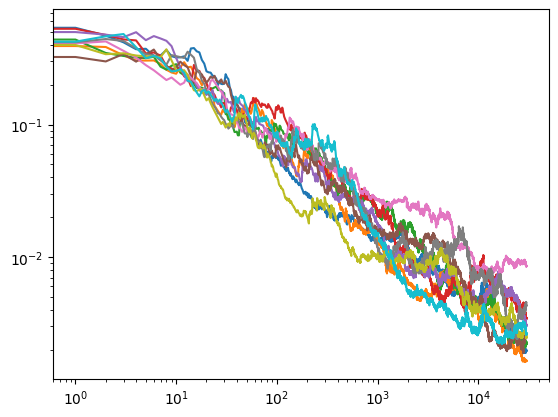

In [ ]:
# Load data from QST_settings.npy
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"
qst = QST.load_data(base_path)


# You can perform BME with the uncorrected POVM (default setting: Pauli-6)
qst.perform_BME()
uncorrected_infidelity = qst.get_infidelity()


# Perform BME with corrected POVM
use_corrected_POVM = True
qst.perform_BME(use_corrected_POVM)
corrected_infidelity = qst.get_infidelity()


for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()


Example of loading results directly from QST_results.npy

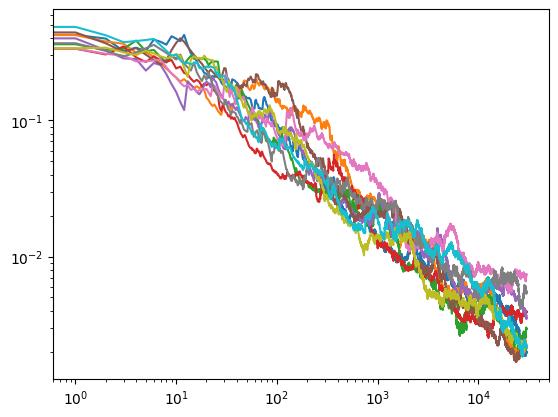

In [ ]:
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"

# The data is saved in the following order
with open(f'{base_path}/QST_results.npy','rb') as f:
    corrected_infidelity = np.load(f)
    uncorrected_infidelity = np.load(f)
    uncorrected_rho_est = np.load(f)
    corrected_rho_estm = np.load(f)
    
for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()
